Activate the environment of the Project.

In [1]:
; cd "~"/CODE/AttentionDCA.jl

/Users/francescocaredda/CODE/AttentionDCA.jl


In [2]:
using Pkg
Pkg.activate(".") #insert the path to the project

  Activating project at `~/CODE/AttentionDCA.jl`


If the package has been added to the general environment, then skip the first cell and run;

In [3]:
using AttentionDCA
using PyPlot #or alternatively Plots

# Standard version

To run the trainer it is possibile to pass the string to the fasta file msa as in:

In [4]:
out_std = trainer("../DataAttentionDCA/data/PF00014/PF00014_mgap6.fasta.gz",100,H=32, d=23,structfile="../DataAttentionDCA/data/PF00014/PF00014_struct.dat");
# regularization and learning rate are controlled by
# η::Float64 = 0.005,
# λ::Float64 = 0.001

removing duplicate sequences... done: 13600 -> 8871
θ = 0.33088461264011026 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
preprocessing took 0.29407425 seconds
Epoch 1 loss = 253.12538 	 PPV@L = 0.453 	 First Error = 2
Epoch 2 loss = 229.15577 	 PPV@L = 0.528 	 First Error = 3
Epoch 3 loss = 203.69363 	 PPV@L = 0.566 	 First Error = 2
Epoch 4 loss = 178.33528 	 PPV@L = 0.509 	 First Error = 4
Epoch 5 loss = 158.45001 	 PPV@L = 0.528 	 First Error = 5
Epoch 6 loss = 143.97547 	 PPV@L = 0.547 	 First Error = 7
Epoch 7 loss = 133.01843 	 PPV@L = 0.585 	 First Error = 7
Epoch 8 loss = 124.40283 	 PPV@L = 0.604 	 First Error = 9
Epoch 9 loss = 117.6134 	 PPV@L = 0.66 	 First Error = 9
Epoch 10 loss = 112.26845 	 PPV@L = 0.679 	 First Error = 9
Epoch 11 loss = 108.04217 	 PPV@L = 0.736 	 First Error = 10
Epoch 12 loss = 104.68374 	 PPV@L = 0.774 	 First Error = 11
Epoch 13 loss = 101.98171 	 PPV@L = 0.811 	 First Error = 16
Epoch 14 loss = 99.77818 	 PPV@L = 0.83 	 First Error = 

The argument <br>

    structfile="../DataAttentionDCA/data/PF00014/PF00014_struct.dat"

contains the file to the structure of the prototypical protein of the MSA and it is used to evaluate the PPV

The output "out_std" contains $(Q,K,V)$ matrices with dimensions $(H,d,L)$ for $Q$ and $K$, $(H,q,q)$ for $V$, where:<br>

$H=$number of heads<br>
$d=$internal dimension<br>
$q=$alphabet size<br>
$L=$family length<br>

Instead of the fasta file, it is also possible to run the trainer with a Matrix of Integers representing the MSA with dimensions $(L,M)$ where $M$ is the depth of the family, and a weigth vector of dimension $M$. They should be passed as a tuple $(Z,W)$

In [5]:
Z,W = AttentionDCA.quickread("../DataAttentionDCA/data/PF00014/PF00014_mgap6.fasta.gz");

In [6]:
out_std = trainer((Z,W),100,H=32, d=23,structfile="../DataAttentionDCA/data/PF00014/PF00014_struct.dat");

Epoch 1 loss = 251.94351 	 PPV@L = 0.396 	 First Error = 2
Epoch 2 loss = 227.35899 	 PPV@L = 0.453 	 First Error = 2
Epoch 3 loss = 201.37248 	 PPV@L = 0.415 	 First Error = 2
Epoch 4 loss = 176.62495 	 PPV@L = 0.453 	 First Error = 2
Epoch 5 loss = 157.55026 	 PPV@L = 0.415 	 First Error = 1
Epoch 6 loss = 143.54297 	 PPV@L = 0.453 	 First Error = 1
Epoch 7 loss = 132.75856 	 PPV@L = 0.453 	 First Error = 6
Epoch 8 loss = 124.26273 	 PPV@L = 0.547 	 First Error = 5
Epoch 9 loss = 117.58244 	 PPV@L = 0.604 	 First Error = 5
Epoch 10 loss = 112.30051 	 PPV@L = 0.642 	 First Error = 5
Epoch 11 loss = 108.11606 	 PPV@L = 0.642 	 First Error = 5
Epoch 12 loss = 104.77299 	 PPV@L = 0.66 	 First Error = 4
Epoch 13 loss = 102.062 	 PPV@L = 0.66 	 First Error = 5
Epoch 14 loss = 99.85982 	 PPV@L = 0.66 	 First Error = 5
Epoch 15 loss = 98.04841 	 PPV@L = 0.698 	 First Error = 5
Epoch 16 loss = 96.54005 	 PPV@L = 0.717 	 First Error = 5
Epoch 17 loss = 95.26385 	 PPV@L = 0.736 	 First Error = 

Computing and plotting the PPV

In [7]:
include("notebooks/useful_functions.jl")

attention_PPV (generic function with 3 methods)

In [8]:
truth = AttentionDCA.compute_actualPPV("../DataAttentionDCA/data/PF00014/PF00014_struct.dat"); #ideal ppv 
ppv_frobenious_norm = compute_PPV(score(out_std),"../DataAttentionDCA/data/PF00014/PF00014_struct.dat"); #ppv from the frobenious norm of the full interaction tensor
ppv_attention_score = attention_PPV(out_std..., mean, "../DataAttentionDCA/data/PF00014/PF00014_struct.dat"); #ppv from the attention score averaged through the heads

l = 417
L = 1378
trivial contacts = 235


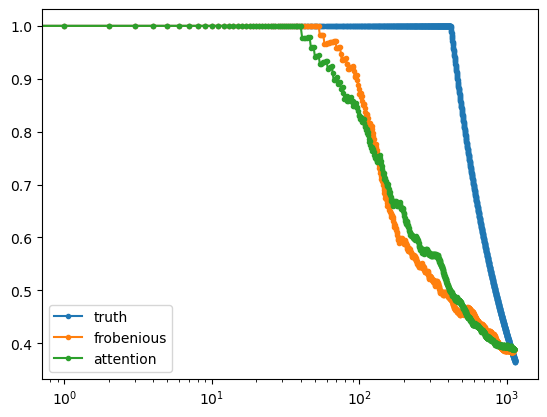

In [9]:
close("all")
semilogx(truth,".-")
semilogx(ppv_frobenious_norm,".-")
semilogx(ppv_attention_score,".-")
legend(["truth", "frobenious", "attention"]);

# Autoregressive version

Similarly as before:

In [10]:
out_ar = artrainer("../DataAttentionDCA/data/PF00014/PF00014_mgap6.fasta.gz", 100,H=32, d=23, λ=0.0001); # no structure file
# regularization and learning rate are controlled by
# η::Float64 = 0.005,
# λ::Float64 = 0.0001
# A larger regularization gives a better contact prediction, while a lower one an improved generativity

removing duplicate sequences... done: 13600 -> 8871
θ = 0.33088461264011026 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
preprocessing took 0.085645167 seconds
Epoch 1 loss = 152.97641
Epoch 2 loss = 143.29002
Epoch 3 loss = 130.86167
Epoch 4 loss = 119.12892
Epoch 5 loss = 111.34824
Epoch 6 loss = 106.10605
Epoch 7 loss = 102.80868
Epoch 8 loss = 100.54559
Epoch 9 loss = 98.8703
Epoch 10 loss = 97.58127
Epoch 11 loss = 96.55374
Epoch 12 loss = 95.71237
Epoch 13 loss = 95.00283
Epoch 14 loss = 94.39481
Epoch 15 loss = 93.8639
Epoch 16 loss = 93.39192
Epoch 17 loss = 92.97226
Epoch 18 loss = 92.59369
Epoch 19 loss = 92.24917
Epoch 20 loss = 91.92997
Epoch 21 loss = 91.63365
Epoch 22 loss = 91.3612
Epoch 23 loss = 91.10739
Epoch 24 loss = 90.86979
Epoch 25 loss = 90.64277
Epoch 26 loss = 90.42962
Epoch 27 loss = 90.23118
Epoch 28 loss = 90.04692
Epoch 29 loss = 89.86892
Epoch 30 loss = 89.70043
Epoch 31 loss = 89.53899
Epoch 32 loss = 89.38793
Epoch 33 loss = 89.24093
Epoch 

Here the output "out" is a tuple, with "out[1]", "out[2]" and "out[3]" containing respectively the "ArNet", "ArVar" and $(Q,K,V)$ matrices. The ArNet contains the interaction tensor and field (put to zero) inferred by the model, while ArVar the parameters of the model and the family.

In [11]:
out_ar[1] |> typeof |> println
out_ar[2] |> typeof |> println
out_ar[3] |> typeof |> println

ArDCA.ArNet
ArDCA.ArVar{Int64}
@NamedTuple{Q::Array{Float64, 3}, K::Array{Float64, 3}, V::Array{Float64, 3}}


Computing the epistatic score ppv:

In [12]:
ppv_epistatic = compute_PPV(out_ar[1],out_ar[2],1,"../DataAttentionDCA/data/PF00014/PF00014_struct.dat");

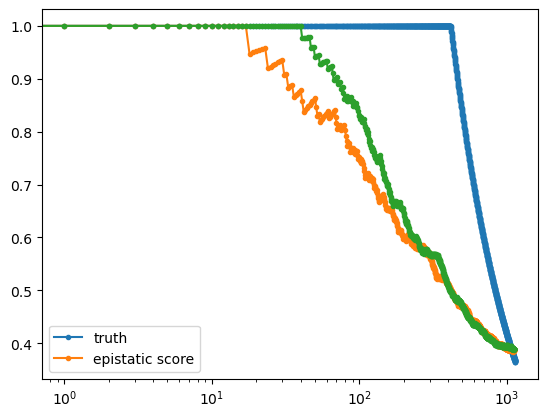

In [13]:
close("all")
semilogx(truth,".-")
semilogx(ppv_epistatic,".-")
semilogx(ppv_attention_score,".-")
legend(["truth", "epistatic score"]);

Generativity:

In [14]:
#Sampling 
Zsample = sample(out_ar[1],10000);
#Computing frequencies
f1s, f2s = compute_freq(Zsample); #1-site, 2-site
cs = f2s - f1s*f1s'; #2-site connected corr


#Compare to natural MSA
f1, f2, = compute_freq(Z,W)
c = f2 - f1*f1';

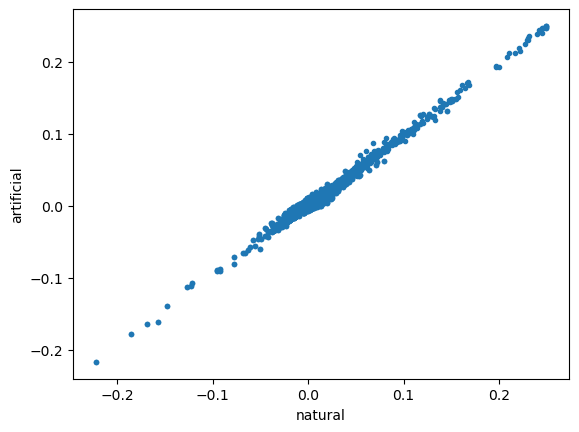

In [15]:
plot(c[:],cs[:],".")
xlabel("natural")
ylabel("artificial");


# Multi-Family Standard

In [16]:
out_mf = multi_trainer(["../DataAttentionDCA/data/PF00014/PF00014_mgap6.fasta.gz", "../DataAttentionDCA/data/PF00763/PF00763_full.fasta"],[30,30],128,[5,18]);

# Alternatively out = multi_trainer([(Z1,W1),(Z2,W2)],[n_epochs1,n_epochs2],H,[d1,d2], etc...)

removing duplicate sequences... done: 13600 -> 8871
θ = 0.33088461264011026 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
removing duplicate sequences... done: 11418 -> 10886
θ = 0.3258239720476657 threshold = 37.0
M = 10886 N = 116 Meff = 2892.132390365238
Epoch 1 loss PF1 = 721.22178 loss PF2 = 819.99612 -> Total loss = 1541.2179
Epoch 2 loss PF1 = 233.90907 loss PF2 = 330.60077 -> Total loss = 564.50984
Epoch 3 loss PF1 = 119.19711 loss PF2 = 211.69859 -> Total loss = 330.8957
Epoch 4 loss PF1 = 96.57021 loss PF2 = 185.63278 -> Total loss = 282.20299
Epoch 5 loss PF1 = 91.81011 loss PF2 = 177.74522 -> Total loss = 269.55533
Epoch 6 loss PF1 = 90.08587 loss PF2 = 173.41468 -> Total loss = 263.50055
Epoch 7 loss PF1 = 89.03517 loss PF2 = 170.11277 -> Total loss = 259.14794
Epoch 8 loss PF1 = 88.19333 loss PF2 = 167.37756 -> Total loss = 255.57089
Epoch 9 loss PF1 = 87.44808 loss PF2 = 164.90569 -> Total loss = 252.35377
Epoch 10 loss PF1 = 86.85902 loss PF2 = 162.8552 -> T

The output "out" is a vector of [Qs,Ks] for each family and a single [V] shared across multiple families. 

Print PPV of the two families

In [17]:
truth1 = AttentionDCA.compute_actualPPV("../DataAttentionDCA/data/PF00014/PF00014_struct.dat");
ppv1_frobenious = compute_PPV(score(out_mf.Qs[1], out_mf.Ks[1], out_mf.V), "../DataAttentionDCA/data/PF00014/PF00014_struct.dat");

l = 417
L = 1378
trivial contacts = 235


In [18]:
truth2 = AttentionDCA.compute_actualPPV("../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat");
ppv2_frobenious = compute_PPV(score(out_mf.Qs[2], out_mf.Ks[2], out_mf.V), "../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat");

l = 980
L = 6670
trivial contacts = 592


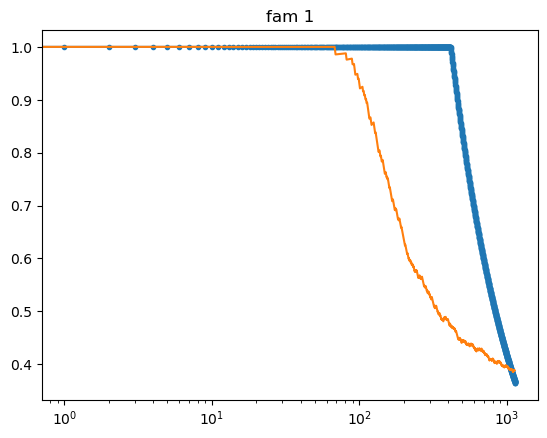

In [19]:
semilogx(truth1, ".-");
semilogx(ppv1_frobenious); title("fam 1");

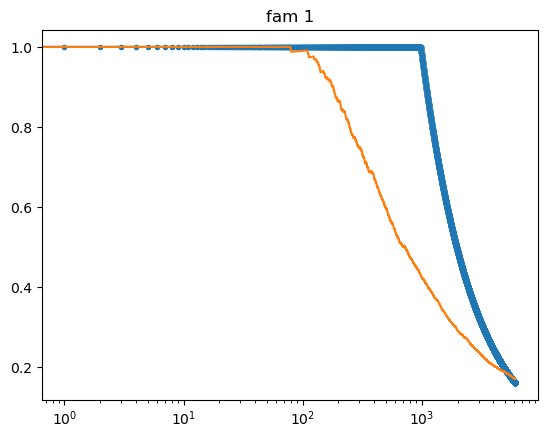

PyObject Text(0.5, 1.0, 'fam 1')

In [20]:
semilogx(truth2, ".-");
semilogx(ppv2_frobenious); title("fam 1")